## Detecting Anomalies in Images  

Anomaly detection deals with the problem of finding data items that do not follow the patterns of the majority of data. The task is to distinguish good items from anomalous items. This can be defined as a binary classification problem and as such solved with supervised learning techniques. However, classes can be highly imbalanced.

Imagine an industrial manufacturing processes, where millions of parts are produced every day, but 1 percent of the production may be defective. A supervised learning approach would clearly suffer from this imbalance. Auto-encoders however are perfect for this situation, because they can be trained on normal parts and don't require annotated data. Once trained, we can give it a feature representation for a part and compare autoencoder output with input. The larger the difference, the more likely the input contains an anomaly.

Auto-encoders consist of two parts: an encoder that encodes the input data using a reduced representation and a decoder that attempts to reconstruct the original input data from the reduced representation. The network is subject to constraints that force the auto-encoder to learn a compressed representation of the training set. It does this in an unsupervised manner and is therefore most suitable for problems related to anomaly detection.

This notebook gives an example for an auto-encoder trained on [UCSD Anomaly Detection Dataset](http://www.svcl.ucsd.edu/projects/anomaly/dataset.htm)

Let's start by downloading and extracting the dataset:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# change directory

In [2]:
cd '/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection'

/content/drive/.shortcut-targets-by-id/11sD5joH1cdVIFWTqX5fi8wpJhdmkAE7N/Anomaly Detection/Anomaly_Detection


In [ ]:
#!tar -xzvf "/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/UCSD_Anomaly_Dataset.tar.gz"

Streaming output truncated to the last 5000 lines.
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/139.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/002.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/060.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/085.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/067.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/127.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/131.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/012.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/148.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/144.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/015.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/009.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/102.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/143.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/078.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/017.bmp
UCSD_

## Installation and First Steps with MXNet

MXNet is not pre-installed in the Colab notebooks, but before installing it we need to figure out which version of CUDA Colab is running on the background. For this we just run a simple command:

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


## CUDA and MXNet

Now that we now what version of CUDA the Colab notebooks is using we have to match it with the MXNet's pip package. In this case, Colab is using CUDA 11.0 so we add 'cu110' to the name of the package:

In [3]:
!pip install mxnet-cu110

     |████████████████████████████████| 323.5MB 50kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
import glob
import numpy as np
from urllib.request import urlopen
import tarfile
import os
import mxnet as mx
from mxnet import gluon
from PIL import Image
from scipy import signal
from matplotlib import pyplot as plt

print(mx.__version__)

1.8.0


In [ ]:
if not os.path.isfile("UCSD_Anomaly_Dataset.tar.gz"):
  response = urlopen("http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz")
  html = response.read()
  tar = tarfile.open("/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/UCSD_Anomaly_Dataset.tar.gz")
  tar.extractall()
  tar.close()

### Convolutional Autoencoder (CAE)

Let's define the network structure. The encoder consists of two convolutional and two MaxPooling layers. Encoder and Decoder are connected by a fully connected layer. The larger this bottleneck, the more information can be reconstructed. The decoder consists of two Upsampling layers and two Deconvolutions.

![Autoencoder](https://raw.githubusercontent.com/NRauschmayr/Anomaly_Detection/master/data/network.png "")

In [ ]:
class ConvolutionalAutoencoder(gluon.nn.HybridBlock):
    
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        
        with self.name_scope():
            self.encoder = gluon.nn.HybridSequential()
            with self.encoder.name_scope():
                self.encoder.add(gluon.nn.Conv2D(32, 5, activation='relu'))
                self.encoder.add(gluon.nn.MaxPool2D(2))
                self.encoder.add(gluon.nn.Conv2D(32, 5, activation='relu'))
                self.encoder.add(gluon.nn.MaxPool2D(2))
                self.encoder.add(gluon.nn.Dense(2000))

            self.decoder = gluon.nn.HybridSequential()
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Dense(32*22*22, activation='relu'))
                self.decoder.add(gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')))
                self.decoder.add(gluon.nn.Conv2DTranspose(32, 5, activation='relu'))
                self.decoder.add(gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')))
                self.decoder.add(gluon.nn.Conv2DTranspose(1, kernel_size=5, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        x = self.encoder(x)
        x = self.decoder[0](x)
        x = x.reshape((-1,32,22,22))
        x = self.decoder[1:](x)

        return x

We train the Autoencoder for 30 epochs and with a batch size of 32.

In [ ]:
ctx = mx.cpu()
num_epochs = 30
batch_size = 32

Images from the folder `UCSDped1` have the format 158x238 pixels. They are rescaled to 100x100 and normalized.

In [ ]:
files = sorted(glob.glob('/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/*/*'))
a = np.zeros((len(files),1,100,100))

for idx, filename in enumerate(files):
    im = Image.open(filename)
    im = im.resize((100,100))
    a[idx,0,:,:] = np.array(im, dtype=np.float32)/255.0

dataset = gluon.data.ArrayDataset(mx.nd.array(a, dtype=np.float32))
dataloader = gluon.data.DataLoader(dataset, batch_size=batch_size, last_batch='rollover',shuffle=True)
print("Dataset Loaded Successfully!!")

Dataset Loaded Successfully!!


Intialize the network and define loss function.

In [ ]:
model = ConvolutionalAutoencoder()
model.hybridize()
model.collect_params().initialize(mx.init.Xavier('gaussian'), ctx=ctx)
loss_function = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 1e-4, 'wd': 1e-5})

The following code defines the training loop:

In [ ]:
for epoch in range(num_epochs):
    
    for image_batch in dataloader:
        
        image = image_batch.as_in_context(ctx)

        with mx.autograd.record():
            output = model(image_batch)
            loss = loss_function(output, image_batch)

        loss.backward()
        optimizer.step(image.shape[0])
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, mx.nd.mean(loss).asscalar()))

model.save_parameters("/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/saved model/autoencoder_ucsd.params")

Streaming output truncated to the last 5000 lines.
epoch [7/30], loss:0.0010
epoch [7/30], loss:0.0008
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0008
epoch [7/30], loss:0.0008
epoch [7/30], loss:0.0008
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0008
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0008
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0010
epoch [7/30], loss:0.0008
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0008
epoch [7/30], loss:0.0010
epoch [7/30], loss:0.0008
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0011
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0008
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0007
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0009
epoch [7/30], loss:0.0008
epoch [7/30], loss:0.0009
epoch [7/30],

Now that the Autoencoder is trained, we can use our test dataset, which contains some anomalies. We focus here on `Test024`, which is a video sequence with a golf cart that should be detected as anomaly. 

In [ ]:
files = sorted(glob.glob('/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/*'))

a = np.zeros((len(files),1,100,100))

for idx,filename in enumerate(files):
    im = Image.open(filename)
    im = im.resize((100,100))
    a[idx,0,:,:] = np.array(im, dtype=np.float32)/255.0

dataset = gluon.data.ArrayDataset(mx.nd.array(a, dtype=np.float32))
dataloader = gluon.data.DataLoader(dataset, batch_size=1)

A helper function that will plot input and output images and the differnce between them.

In [ ]:
def plot(img, output, diff, H, threshold, counter):
    
    fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('diff ')
    ax3.set_title('anomalies')
    
    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest') 
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')   
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')  
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    
    x,y = np.where(H > threshold)
    ax3.scatter(y,x,color='red',s=0.1) 

    plt.axis('off')
    
    fig.savefig('/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/images/' + str(counter) + '.png')

Let's iterate over the test images. We compute the difference between input and output and create a pixel map `H` with a 4x4 convolution kernel. If a pixel value in `H` is larger than 4 times 255 it will be marked as anomaly. The maximum value for each pixel in `H` is 4x4x255. We perform this step, so that pixels will be marked only when their neighboring pixels are also anomalous. 

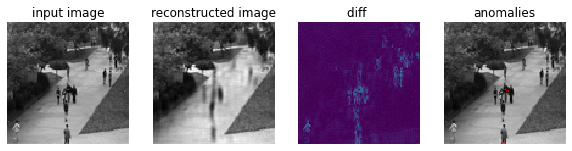

In [ ]:
threshold = 4*255
counter = 0
#try:
 #   os.mkdir("images")
#except:
 #   pass

for image in dataloader:
    
    counter = counter + 1
    img = image.as_in_context(mx.cpu())

    output = model(img)
    output = output.transpose((0,2,3,1))
    image = image.transpose((0,2,3,1))
    output = output.asnumpy()*255
    img = image.asnumpy()*255
    diff = np.abs(output-img)
    
    tmp = diff[0,:,:,0]
    H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')
 
    plot(img[0,:,:,0], output[0,:,:,0], diff[0,:,:,0], H, threshold, counter)
    break

# Code to generate complete frames

In [9]:
import mxnet as mx
from mxnet import gluon

class ConvolutionalAutoencoder(gluon.nn.HybridBlock):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        with self.name_scope():
            self.encoder = gluon.nn.HybridSequential(prefix="")
            with self.encoder.name_scope():
                self.encoder.add(gluon.nn.Conv2D(32, 5, padding=0, activation='relu'))
                self.encoder.add(gluon.nn.MaxPool2D(2))
                self.encoder.add(gluon.nn.Conv2D(32, 5, padding=0, activation='relu'))
                self.encoder.add(gluon.nn.MaxPool2D(2))
                self.encoder.add(gluon.nn.Dense(2000))

            self.decoder = gluon.nn.HybridSequential(prefix="")
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Dense(32*22*22, activation='relu'))
                self.decoder.add(gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')))
                self.decoder.add(gluon.nn.Conv2DTranspose(32, 5, activation='relu'))
                self.decoder.add(gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')))
                self.decoder.add(gluon.nn.Conv2DTranspose(1, kernel_size=5, activation='sigmoid'))


    def hybrid_forward(self, F, x):
        x = self.encoder(x)
        x = self.decoder[0](x)
        x = x.reshape((-1,32,22,22))
        x = self.decoder[1:](x)

        return x

def load_model():
  model = ConvolutionalAutoencoder()
  model.load_parameters("/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/saved model/autoencoder_ucsd.params", ctx=mx.gpu())
  return model

In [10]:
def plot_images(path, model, params_file, ctx, output_path="img", stacked=False, lstm=False):

  if not stacked:
    files = sorted(glob.glob('/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/*'))
    a = np.zeros((len(files),1,100,100))

    for idx,filename in enumerate(files):
      im = Image.open(filename)
      im = im.resize((100,100))
      a[idx,0,:,:] = np.array(im, dtype=np.float32)/255.0

    dataset = gluon.data.ArrayDataset(mx.nd.array(a, dtype=np.float32))
    dataloader = gluon.data.DataLoader(dataset, batch_size=1)
  

  counter = 0
  model.load_parameters(params_file, ctx=ctx)
  
  try:
    os.mkdir(output_path)
  except:
    pass

  for image in dataloader:

    # perform inference
    image = image.as_in_context(ctx)
    if not lstm:
      reconstructed = model(image)
    else:
      states = model.temporal_encoder.begin_state(batch_size=1, ctx=ctx)
      reconstructed, states = model(image, states)
    #compute difference between reconstructed image and input image 
    reconstructed = reconstructed.asnumpy()
    image = image.asnumpy()
    diff = np.abs(reconstructed-image)

    # in case of stacked frames, we need to compute the regularity score per pixel
    if stacked:
       image    = np.sum(image, axis=1, keepdims=True)
       reconstructed = np.sum(reconstructed, axis=1, keepdims=True)
       diff_max = np.max(diff, axis=1)
       diff_min = np.min(diff, axis=1)
       regularity = diff_max - diff_min
       # perform convolution on regularity matrix
       H = signal.convolve2d(regularity[0,:,:], np.ones((4,4)), mode='same')
    else:
      # perform convolution on diff matrix
      H = signal.convolve2d(diff[0,0,:,:], np.ones((4,4)), mode='same')

    # if neighboring pixels are anamolous, then mark the current pixe
    x,y = np.where(H > 4)

    # plt input image, reconstructed image and difference between both
    fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()

    ax0.imshow(image[0,0,:,:], cmap=plt.cm.gray, interpolation='nearest')
    ax0.set_title('input image')
    ax1.imshow(reconstructed[0,0,:,:], cmap=plt.cm.gray, interpolation='nearest')
    ax1.set_title('reconstructed image')
    ax2.imshow(diff[0,0,:,:], cmap=plt.cm.viridis, vmin=0, vmax=1, interpolation='nearest')
    ax2.set_title('diff ')
    ax3.imshow(image[0,0,:,:], cmap=plt.cm.gray, interpolation='nearest')
    ax3.scatter(y,x,color='red',s=0.3)
    ax3.set_title('anomalies')
    plt.axis('off')
    
     # save figure
    counter = counter + 1
    fig.savefig(output_path + "/" + str(counter) + '.png', bbox_inches = 'tight', pad_inches = 0.5)
    plt.close(fig)

In [11]:
ctx = mx.cpu()
model = ConvolutionalAutoencoder()
params_file = "/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/saved model/autoencoder_ucsd.params"
#model = load_model()
test_directory = '/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/*'
plot_images( test_directory, model, params_file, ctx, output_path="convAE")

#### Example Video (with Dense layer):
<img src="https://github.com/NRauschmayr/Anomaly_Detection/raw/master/data/autoencoder_dense.gif" width="800" height="300">

As we can see in the video, the golf cart is successfully identified as an anomaly. The autoencoder has learned to reconstruct human beings well, but it struggles with objects that it has not seen during training.
The dimension of the bottleneck layer will influence how much information is transmitted between encoder and decoder. If we set it too large or even remove it, then images will be reconstructed quite well. In the video below we removed the layer, so information flows from the second MaxPooling layer directly to the first Upsampling layer. 

#### Example Video (without Dense layer):
<img src="https://github.com/NRauschmayr/Anomaly_Detection/raw/master/data/autoencoder_no_dense.gif" width="800" height="300">
As we can see the network can reconstruct persons and other objects much better than the network with bottleneck layer. But it also becomes more challenging to detect anomalies.

## Spatio-Temporal Stacked Frame AutoEncoder 
One problem of the standard CAE is that it does not take into account the temporal aspect of sequence of images. As such identifying certain anomalies like a person moving faster than the average cannot be easily detected. For instance in the video above the person on skateboard nor the person on the bicycle are detected as an anomaly. The paper ["Learning Temporal Regularity in Video Sequences"](https://arxiv.org/abs/1604.04574) describes an autoencoder that can also learn spatio-temporal structures in datasets. Instead of considering only one image at a time we consider now `n` images at a time. CAE takes the input in the form of `[batch_size, 1, width, height]`) and the spatio-temporal autoencoder takes `[batch_size, n, width, height]`.

In [ ]:
class convSTAE(gluon.nn.HybridBlock):
    def __init__(self):
        super(convSTAE, self).__init__()
        with self.name_scope():
            self.encoder = gluon.nn.HybridSequential(prefix="encoder")
            with self.encoder.name_scope():
                self.encoder.add(gluon.nn.Conv2D(512, kernel_size=15, strides=4, activation='relu'))
                self.encoder.add(gluon.nn.BatchNorm())
                self.encoder.add(gluon.nn.MaxPool2D(2))
                self.encoder.add(gluon.nn.BatchNorm())
                self.encoder.add(gluon.nn.Conv2D(256, kernel_size=4, activation='relu'))
                self.encoder.add(gluon.nn.BatchNorm())
                self.encoder.add(gluon.nn.MaxPool2D(2))
                self.encoder.add(gluon.nn.BatchNorm())
                self.encoder.add(gluon.nn.Conv2D(128, kernel_size=3, activation='relu'))
                self.encoder.add(gluon.nn.BatchNorm())
                
            self.decoder = gluon.nn.HybridSequential(prefix="decoder")
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Conv2DTranspose(channels=256, kernel_size=3, activation='relu'))
                self.decoder.add(gluon.nn.BatchNorm())
                self.decoder.add(gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')))
                self.decoder.add(gluon.nn.BatchNorm())
                self.decoder.add(gluon.nn.Conv2DTranspose(channels=512, kernel_size=4, activation='relu'))
                self.decoder.add(gluon.nn.BatchNorm())
                self.decoder.add(gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')))
                self.decoder.add(gluon.nn.BatchNorm())
                self.decoder.add(gluon.nn.Conv2DTranspose(channels=10, kernel_size=15, strides=4, activation='sigmoid'))


    def hybrid_forward(self, F, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

We train the Autoencoder for 30 epochs and with a batch size of 32.

In [ ]:
ctx = mx.cpu()
num_epochs = 30
batch_size = 32

The input dataset needs to be modified: instead of 1 channel, it contains now ```n``` channels. 

In [ ]:
files = sorted(glob.glob('/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/*/*'))
argument = False # True or False  RAM tends to crash when set to true 

if argument:
  files = files + files[2:] + files[4:] + files[6:] + files[8:]

n=10
a = np.zeros((int(len(files)/n), n, 227, 227))
i = 0
idx = 0

for filename in files:
    im = Image.open(filename)
    im = im.resize((227,227))
    a[idx,i,:,:] = np.array(im, dtype=np.float32)/255.0
    i = i + 1
    if i > n-1:
      idx = idx + 1
      i = 0
dataset = gluon.data.ArrayDataset(mx.nd.array(a, dtype=np.float32))
dataloader = gluon.data.DataLoader(dataset, batch_size=batch_size, last_batch='rollover',shuffle=True)
print("Dataset Loaded Successfully!!")

Dataset Loaded Successfully!!


Intialize the network and define loss function.

In [ ]:
model = convSTAE()
model.hybridize()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
loss_function = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 1e-4, 'wd': 1e-5, 'epsilon':1e-6})

The following code defines the training loop:

In [ ]:
for epoch in range(num_epochs):
    
    for image_batch in dataloader:
        
        image = image_batch.as_in_context(ctx)

        with mx.autograd.record():
            output = model(image_batch)
            loss = loss_function(output, image_batch)

        loss.backward()
        optimizer.step(batch_size)
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, mx.nd.mean(loss).asscalar()))

model.save_parameters("/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/saved model/autoencoder_ucsd_convstae.params")

epoch [1/30], loss:0.0308
epoch [1/30], loss:0.0290
epoch [1/30], loss:0.0261
epoch [1/30], loss:0.0225
epoch [1/30], loss:0.0210
epoch [1/30], loss:0.0190
epoch [1/30], loss:0.0192
epoch [1/30], loss:0.0185
epoch [1/30], loss:0.0179
epoch [1/30], loss:0.0175
epoch [1/30], loss:0.0165
epoch [1/30], loss:0.0160
epoch [1/30], loss:0.0155
epoch [1/30], loss:0.0151
epoch [1/30], loss:0.0152
epoch [1/30], loss:0.0143
epoch [1/30], loss:0.0140
epoch [1/30], loss:0.0142
epoch [1/30], loss:0.0139
epoch [1/30], loss:0.0132
epoch [1/30], loss:0.0131
epoch [2/30], loss:0.0128
epoch [2/30], loss:0.0127
epoch [2/30], loss:0.0121
epoch [2/30], loss:0.0122
epoch [2/30], loss:0.0122
epoch [2/30], loss:0.0119
epoch [2/30], loss:0.0119
epoch [2/30], loss:0.0113
epoch [2/30], loss:0.0117
epoch [2/30], loss:0.0112
epoch [2/30], loss:0.0108
epoch [2/30], loss:0.0111
epoch [2/30], loss:0.0111
epoch [2/30], loss:0.0103
epoch [2/30], loss:0.0105
epoch [2/30], loss:0.0103
epoch [2/30], loss:0.0095
epoch [2/30]

KeyboardInterrupt: ignored

Now that the Autoencoder is trained, we can use our test dataset, which contains some anomalies. We focus here on `Test024`, which is a video sequence with a golf cart that should be detected as anomaly. 

In [ ]:
files = sorted(glob.glob('/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/*'))

a = np.zeros((len(files),1,100,100))

for idx,filename in enumerate(files):
    im = Image.open(filename)
    im = im.resize((100,100))
    a[idx,0,:,:] = np.array(im, dtype=np.float32)/255.0

dataset = gluon.data.ArrayDataset(mx.nd.array(a, dtype=np.float32))
dataloader = gluon.data.DataLoader(dataset, batch_size=1)

A helper function that will plot input and output images and the differnce between them.

In [ ]:
def plot(img, output, diff, H, threshold, counter):
    
    fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('diff ')
    ax3.set_title('anomalies')
    
    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest') 
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')   
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')  
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    
    x,y = np.where(H > threshold)
    ax3.scatter(y,x,color='red',s=0.1) 

    plt.axis('off')
    
    fig.savefig('/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/images/' + str(counter) + '.png')

Let's iterate over the test images. We compute the difference between input and output and create a pixel map `H` with a 4x4 convolution kernel. If a pixel value in `H` is larger than 4 times 255 it will be marked as anomaly. The maximum value for each pixel in `H` is 4x4x255. We perform this step, so that pixels will be marked only when their neighboring pixels are also anomalous. 

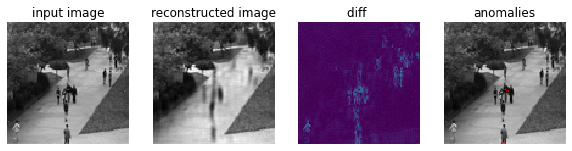

In [ ]:
threshold = 4*255
counter = 0
#try:
 #   os.mkdir("images")
#except:
 #   pass

for image in dataloader:
    
    counter = counter + 1
    img = image.as_in_context(mx.cpu())

    output = model(img)
    output = output.transpose((0,2,3,1))
    image = image.transpose((0,2,3,1))
    output = output.asnumpy()*255
    img = image.asnumpy()*255
    diff = np.abs(output-img)
    
    tmp = diff[0,:,:,0]
    H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')
 
    plot(img[0,:,:,0], output[0,:,:,0], diff[0,:,:,0], H, threshold, counter)
    break

Following shows, that this autoencoder can more accurately detect anomalies such as persons on bicycles or skateboards. 
<img src="https://github.com/NRauschmayr/Anomaly_Detection/raw/master/data/stsae.gif" width="800" height="300">

## Spatio-Temporal Autoencoder with Convolutional LSTMs 

We can enhance the previous model by using convolutions LSTM cells. ConvLSTMs have proven to be effective in video processing, where they can be used to predict next video frames. The paper [Abnormal Event Detection in Videos
using Spatiotemporal Autoencoder](https://arxiv.org/pdf/1701.01546.pdf) describes an autoencoder model, where 10 input frames are stacked together in one cube. They are processed by 2 convolutionals layers (encoder), followed by the temporal enocder/decoder that consists of 3 convolutional LSTMs and last 2 deconvolutional layers that reconstruct the output frames.

In [ ]:
class ConvLSTMAE(gluon.nn.HybridBlock):
    def __init__(self, **kwargs):
        super(ConvLSTMAE, self).__init__(**kwargs)
        with self.name_scope():

          self.encoder = gluon.nn.HybridSequential()
          self.encoder.add(gluon.nn.Conv2D(128, kernel_size=11, strides=4, activation='relu'))
          self.encoder.add(gluon.nn.Conv2D(64, kernel_size=5, strides=2, activation='relu'))

          self.temporal_encoder = gluon.rnn.HybridSequentialRNNCell()
          self.temporal_encoder.add(gluon.contrib.rnn.Conv2DLSTMCell((64,26,26), 64, 3, 3, i2h_pad=1))
          self.temporal_encoder.add(gluon.contrib.rnn.Conv2DLSTMCell((64,26,26), 32, 3, 3, i2h_pad=1))
          self.temporal_encoder.add(gluon.contrib.rnn.Conv2DLSTMCell((32,26,26), 64, 3, 3, i2h_pad=1))

          self.decoder =  gluon.nn.HybridSequential()
          self.decoder.add(gluon.nn.Conv2DTranspose(channels=128, kernel_size=5, strides=2, activation='relu'))
          self.decoder.add(gluon.nn.Conv2DTranspose(channels=10, kernel_size=11, strides=4, activation='sigmoid'))

    def hybrid_forward(self, F, x, states=None, **kwargs):
        x = self.encoder(x)
        x, states = self.temporal_encoder(x, states)
        x = self.decoder(x)

        return x, states

When we initialize the model, we have to create the intital state vector for the LSTMs.

In [ ]:
ctx = mx.cpu()
num_epochs = 30
batch_size = 32

In [ ]:
model = ConvLSTMAE()
model.hybridize()
model.collect_params().initialize(mx.init.Xavier(), ctx=mx.gpu())
states = model.temporal_encoder.begin_state(batch_size=batch_size, ctx=ctx)

The input dataset needs to be modified: instead of 1 channel, it contains now ```n``` channels. 

In [ ]:
files = sorted(glob.glob('/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/*/*'))
argument = False # True or False  RAM tends to crash when set to true 

if argument:
  files = files + files[2:] + files[4:] + files[6:] + files[8:]

n=10
a = np.zeros((int(len(files)/n), n, 227, 227))
i = 0
idx = 0

for filename in files:
    im = Image.open(filename)
    im = im.resize((227,227))
    a[idx,i,:,:] = np.array(im, dtype=np.float32)/255.0
    i = i + 1
    if i > n-1:
      idx = idx + 1
      i = 0
dataset = gluon.data.ArrayDataset(mx.nd.array(a, dtype=np.float32))
dataloader = gluon.data.DataLoader(dataset, batch_size=batch_size, last_batch='rollover',shuffle=True)
print("Dataset Loaded Successfully!!")

Dataset Loaded Successfully!!


Intialize the network and define loss function.

In [ ]:
loss_function = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 1e-4, 'wd': 1e-5, 'epsilon':1e-6})

The following code defines the training loop:

In [ ]:
for epoch in range(num_epochs):
    
    for image_batch in dataloader:
        
        image = image_batch.as_in_context(ctx)
        states = model.temporal_encoder.begin_state(func=mx.nd.zeros, batch_size=batch_size, ctx=ctx)
        
        with mx.autograd.record():
            output, states = model(image_batch,states)
            loss = loss_function(output, image)

        loss.backward()
        optimizer.step(batch_size)
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, mx.nd.mean(loss).asscalar()))

model.save_parameters("/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/saved model/autoencoder_ucsd_convLSTMAE.params")

epoch [1/30], loss:0.0308
epoch [1/30], loss:0.0290
epoch [1/30], loss:0.0261
epoch [1/30], loss:0.0225
epoch [1/30], loss:0.0210
epoch [1/30], loss:0.0190
epoch [1/30], loss:0.0192
epoch [1/30], loss:0.0185
epoch [1/30], loss:0.0179
epoch [1/30], loss:0.0175
epoch [1/30], loss:0.0165
epoch [1/30], loss:0.0160
epoch [1/30], loss:0.0155
epoch [1/30], loss:0.0151
epoch [1/30], loss:0.0152
epoch [1/30], loss:0.0143
epoch [1/30], loss:0.0140
epoch [1/30], loss:0.0142
epoch [1/30], loss:0.0139
epoch [1/30], loss:0.0132
epoch [1/30], loss:0.0131
epoch [2/30], loss:0.0128
epoch [2/30], loss:0.0127
epoch [2/30], loss:0.0121
epoch [2/30], loss:0.0122
epoch [2/30], loss:0.0122
epoch [2/30], loss:0.0119
epoch [2/30], loss:0.0119
epoch [2/30], loss:0.0113
epoch [2/30], loss:0.0117
epoch [2/30], loss:0.0112
epoch [2/30], loss:0.0108
epoch [2/30], loss:0.0111
epoch [2/30], loss:0.0111
epoch [2/30], loss:0.0103
epoch [2/30], loss:0.0105
epoch [2/30], loss:0.0103
epoch [2/30], loss:0.0095
epoch [2/30]

Now that the Autoencoder is trained, we can use our test dataset, which contains some anomalies. We focus here on `Test024`, which is a video sequence with a golf cart that should be detected as anomaly. 

In [ ]:
files = sorted(glob.glob('/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/*'))

a = np.zeros((len(files),1,100,100))

for idx,filename in enumerate(files):
    im = Image.open(filename)
    im = im.resize((100,100))
    a[idx,0,:,:] = np.array(im, dtype=np.float32)/255.0

dataset = gluon.data.ArrayDataset(mx.nd.array(a, dtype=np.float32))
dataloader = gluon.data.DataLoader(dataset, batch_size=1)

A helper function that will plot input and output images and the differnce between them.

In [ ]:
def plot(img, output, diff, H, threshold, counter):
    
    fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('diff ')
    ax3.set_title('anomalies')
    
    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest') 
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')   
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')  
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    
    x,y = np.where(H > threshold)
    ax3.scatter(y,x,color='red',s=0.1) 

    plt.axis('off')
    
    fig.savefig('/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/images/' + str(counter) + '.png')

Let's iterate over the test images. We compute the difference between input and output and create a pixel map `H` with a 4x4 convolution kernel. If a pixel value in `H` is larger than 4 times 255 it will be marked as anomaly. The maximum value for each pixel in `H` is 4x4x255. We perform this step, so that pixels will be marked only when their neighboring pixels are also anomalous. 

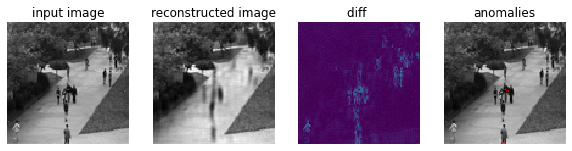

In [ ]:
threshold = 4*255
counter = 0
#try:
 #   os.mkdir("images")
#except:
 #   pass

for image in dataloader:
    
    counter = counter + 1
    img = image.as_in_context(mx.cpu())

    output = model(img)
    output = output.transpose((0,2,3,1))
    image = image.transpose((0,2,3,1))
    output = output.asnumpy()*255
    img = image.asnumpy()*255
    diff = np.abs(output-img)
    
    tmp = diff[0,:,:,0]
    H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')
 
    plot(img[0,:,:,0], output[0,:,:,0], diff[0,:,:,0], H, threshold, counter)
    break

The following video shows the results of the spatio-termporal autoencoder based on convolutional LSTM cells. It achieves very similar results as the previous model.
<img src="https://github.com/NRauschmayr/Anomaly_Detection/raw/master/data/convLSTMAE.gif" width="800" height="300">

# Frame to Gif converter

In [4]:
import imageio
import glob
file = sorted(glob.glob('/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/convAE/*'))
images = []
for filename in file:
    images.append(imageio.imread(filename))
imageio.mimsave('/content/drive/MyDrive/Anomaly Detection/Anomaly_Detection/Gif/Test024.gif', images)